In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random
from typing import List, Tuple

/Users/omarayyub/p/Alphatoe/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)


In [3]:
def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

def get_content_embedding(seq: List) -> torch.Tensor:
    sequence = torch.tensor([seq])
    return model.embed(sequence)

def get_head_attention(seq: torch.Tensor) -> torch.Tensor:
    def hook(module, input, output):
        module.attention = output.clone()
    try:
        handle = model.blocks[0].hook_attn_out.register_forward_hook(hook)
        _ = model(seq)
        attention = model.blocks[0].hook_attn_out.attention
    except Exception as e:
        handle.remove()
        raise e
    
    return attention


In [25]:
winning_moves = [0,1,2]
content_embedding = get_content_embedding(winning_moves)
win_con_embedding = torch.sum(content_embedding[0], dim=0).view(1,1,128)
win_con_embedding.shape
con_emb = win_con_embedding[0,0]

In [26]:
fake_win = torch.tensor([10, 0, 10, 1, 10, 2])
attention = get_head_attention(fake_win)
sliced = attention[0,-1]

In [27]:
stack = torch.stack([con_emb, sliced])
print(stack.shape)
dot = stack @ stack.T
norms = torch.norm(stack, dim=1)
cosine_similarity_matrix = dot / (norms.view(-1, 1) * norms)

print(cosine_similarity_matrix)

torch.Size([2, 128])
tensor([[1.0000, 0.4635],
        [0.4635, 1.0000]], device='mps:0', grad_fn=<DivBackward0>)


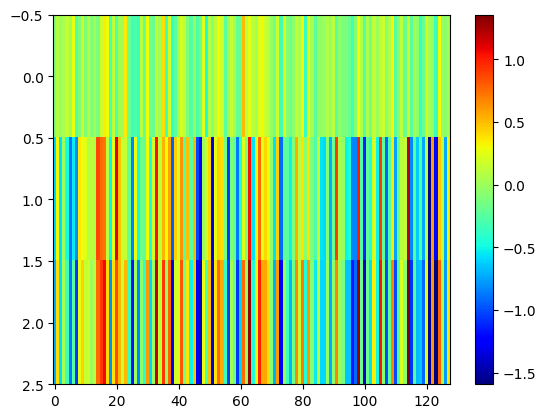

In [38]:
plus_resid = con_emb + sliced
resid_stack = torch.stack([con_emb, sliced, plus_resid])
plt.imshow(resid_stack.detach().cpu().numpy(), cmap='jet', aspect='auto')
plt.colorbar();

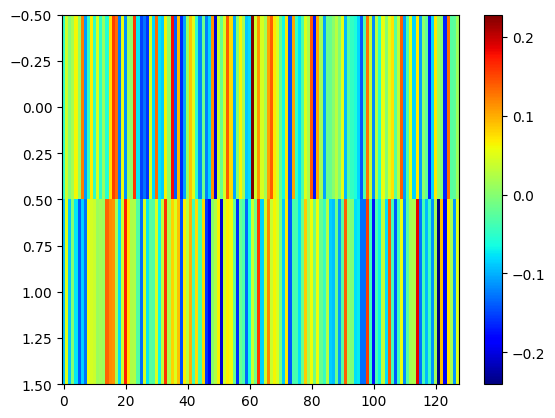

In [41]:
normalized_stack = stack / torch.norm(stack, dim=1, keepdim=True)
plt.imshow(normalized_stack.detach().cpu().numpy(), cmap='jet', aspect='auto')
plt.colorbar();

In [54]:
vector1 = stack[0, :]
vector2 = stack[1, :]


products = vector1 * vector2
absolute_products = np.abs(products.detach().cpu())
sorted_indices = np.argsort(-absolute_products)

print("Sorted indices by contribution:", sorted_indices)
print("Sorted contributions:", absolute_products[sorted_indices])

Sorted indices by contribution: tensor([123,  38, 100,  73,  98,  20,  25,  46,  96,  63,  16,  47,  35,   7,
        115,  91, 114, 110,  66,  59,  27,   6,  33,  18, 124,  53, 119,  41,
         15,  37,  80,  61, 109,  14,  39, 118, 105,  36,  82,  76,  30,  95,
         71,  26,  60,  67,  31,  49,  84,  72,  94,   4,   0,  44,  97,  54,
         68,  78,  64, 107,  23, 102,  43,  74,  51,   9,  32, 106,   8, 126,
         29,  50,  17, 121,  24,  19,  55,  42,  69, 117,  81,  52,  10, 103,
          1, 113,  75,  99,  86,  90, 108,  45,  28,  21,  57, 120, 111, 101,
        112,  12,   5,  62, 127,  65,  89,  58,  11,  77, 125,  56,  85,  88,
         48,   2,  40,  83,  79,  93,  92, 116,  87,  13,  70, 104,  34,  22,
        122,   3])
Sorted contributions: tensor([4.5142e-01, 3.4987e-01, 2.9644e-01, 2.9476e-01, 2.8641e-01, 2.8475e-01,
        2.8417e-01, 2.8063e-01, 2.6520e-01, 2.6240e-01, 2.5071e-01, 2.3530e-01,
        2.0719e-01, 2.0486e-01, 2.0194e-01, 1.9483e-01, 1.8788e-0

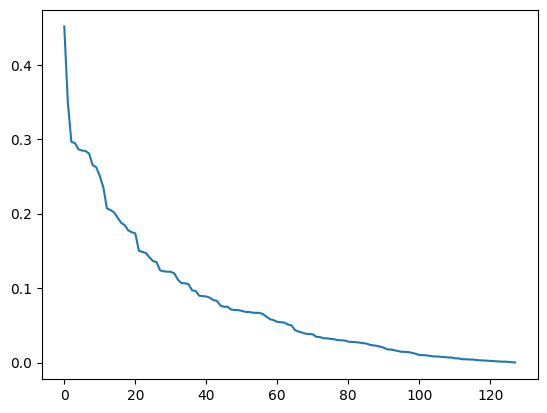

In [92]:
plt.plot(sorted_contributions.detach().cpu().numpy())

In [97]:
random_indices = torch.randperm(128)
mask = torch.zeros_like(vector1)
mask[sorted_indices[:64]] = 1
masked_con = mask * vector1
masked_con = masked_con.view(1,1,128)
anti_mask = torch.zeros_like(vector1)
anti_mask[sorted_indices[64:]] = 1
anti_mask_con = anti_mask * vector1
anti_mask_con = anti_mask_con.view(1,1,128)
con_emb = vector1.view(1,1,128)
rand_mask = torch.zeros_like(vector1)
rand_mask[random_indices[:64]] = 1
rand_mask_con = rand_mask * vector1
rand_mask_con = rand_mask_con.view(1,1,128)

In [99]:
logits_mask_con = model.blocks[0].mlp(masked_con) @ model.W_U
logits_anti_con = model.blocks[0].mlp(anti_mask_con) @ model.W_U
logits_rand_con = model.blocks[0].mlp(rand_mask_con) @ model.W_U
logits_con = model.blocks[0].mlp(con_emb) @ model.W_U


In [100]:
print("masked: " , logits_mask_con)
print("anti mask: " , logits_anti_con)
print("random mask: ", logits_rand_con)
print("content emb logits: " , logits_con)
logits_stack = torch.stack([logits_mask_con[0,0], logits_anti_con[0,0], logits_rand_con[0,0], logits_con[0,0]])

masked:  tensor([[[-5.0805, -6.2001, -6.4384,  2.2922,  0.6294,  3.5914,  0.3217,
           0.8857,  4.0386,  3.6510]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)
anti mask:  tensor([[[-0.9787,  1.0003, -0.3925,  0.1945,  0.6729,  0.9703,  0.5455,
           0.7130, -0.4802, -1.7522]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)
random mask:  tensor([[[-1.0676, -1.0885, -0.0767,  0.3015,  0.8542,  2.9893,  4.1027,
           1.3415,  3.1683, -8.4340]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)
content emb logits:  tensor([[[-5.9231, -5.0234, -6.5849,  2.2584,  1.5988,  4.6090,  1.3839,
           1.4669,  3.4002,  1.6445]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)


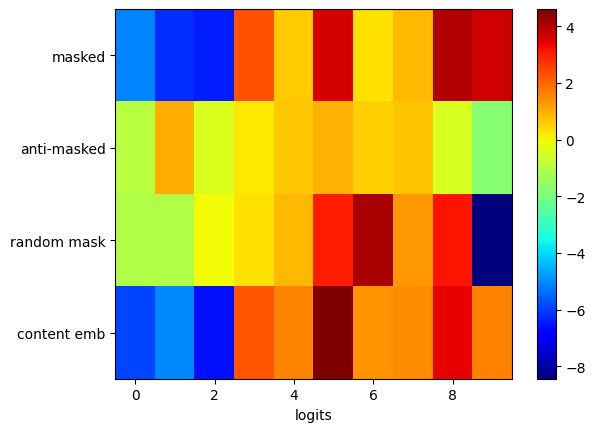

In [101]:
plt.imshow(logits_stack.detach().cpu().numpy(), cmap='jet', aspect='auto')
plt.colorbar()
#y labels
plt.yticks([0,1,2,3], ["masked", "anti-masked", "random mask", "content emb"]);
#xlabel
plt.xlabel("logits")
plt.gcf().set_facecolor("white")